## **RADI608: Data Mining and Machine Learning**

### Assignment: Semi-Supervised Learning
**Romen Samuel Rodis Wabina** <br>
Student, PhD Data Science in Healthcare and Clinical Informatics <br>
Clinical Epidemiology and Biostatistics, Faculty of Medicine (Ramathibodi Hospital) <br>
Mahidol University

Note: In case of Python Markdown errors, you may access the assignment through this GitHub [Link](https://github.com/rrwabina/RADI608/tree/main/Submitted)

##   Question 1
#### Question 1a. From <code>colon.csv</code>, please reduce data dimension by using 2 features (column’s name or gene numbers: <code>T62947</code> and <code>H64807</code>).

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 
from sklearn import datasets
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.semi_supervised import LabelSpreading
from sklearn.metrics import classification_report, confusion_matrix
from collections import Counter

from numpy import mean
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.tree import DecisionTreeClassifier

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline

import random
import warnings
warnings.filterwarnings('ignore')

rng = np.random.RandomState(10)

colon_data = pd.read_csv('../data/colon.csv')
X = colon_data[['T62947', 'H64807']].to_numpy()
y = colon_data[['Class']].to_numpy()

#### Question 1b. Generate labeled and unlabeled data by random selecting 42 samples without replacement and removing their class to perform as unlabeled data. The non-selected 20 samples will be used as labeled data (42:20).

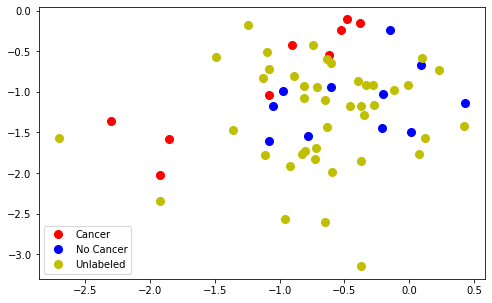

In [2]:
random.seed(30)
index = random.sample(range(len(y)), 42)
labeled = random.sample([x for x in range(max(index)) if x not in index], 20)
X_labeled, y_labeled = X[labeled], y[labeled]
X_unlabel, y_unlabel = X, y.copy()
y_unlabel[index] = 0

def plot_data(X, y):
    y = y.flatten()
    class1 = (y ==  1)
    class2 = (y == -1)
    class3 = (y ==  0)
    plt.figure(figsize=(8, 5))    
    plt.plot(X[:,0][class1], X[:, 1][class1], 'ro', markersize = 8, label = 'Cancer')
    plt.plot(X[:,0][class2], X[:, 1][class2], 'bo', markersize = 8, label = 'No Cancer')
    plt.plot(X[:,0][class3], X[:, 1][class3], 'yo', markersize = 8, label = 'Unlabeled')
    plt.legend(loc = 'lower left')

plot_data(X_unlabel, y_unlabel)

#### c. Perform SVM by using 20 labelled samples.

<Figure size 1080x720 with 0 Axes>

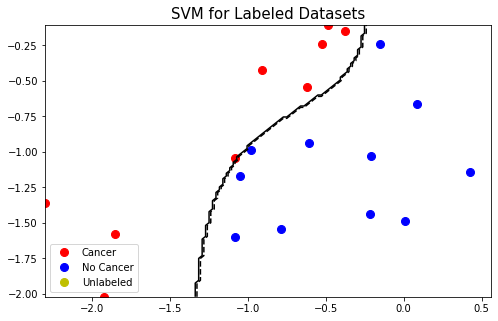

In [3]:
random.seed(413)
svclassifier = SVC(kernel = 'rbf', C = 100, gamma = 1)
svclassifier.fit(X_labeled, y_labeled)

def visualize_boundary(X, y, model, title):
    plt.figure(figsize = (15, 10))
    plot_data(X, y)
    X_21, X_22 = np.meshgrid(np.linspace(X[:,0].min(), X[:,1].max(), num = 100), 
                             np.linspace(X[:,1].min(), X[:,1].max(), num = 100))
    plt.contour(X_21, X_22, model.predict(np.array([X_21.ravel(),X_22.ravel()]).T).reshape(X_21.shape), 1, colors = 'k')
    plt.title(title, size = 15)
    plt.legend(loc = 'lower left')
    plt.show()

random.seed(413)
visualize_boundary(X_labeled, y_labeled, svclassifier, title = 'SVM for Labeled Datasets')

In [4]:
predictions = svclassifier.predict(X_labeled)
print(classification_report(y_labeled, predictions, target_names = ['No Cancer', 'Cancer']))

              precision    recall  f1-score   support

   No Cancer       1.00      1.00      1.00        11
      Cancer       1.00      1.00      1.00         9

    accuracy                           1.00        20
   macro avg       1.00      1.00      1.00        20
weighted avg       1.00      1.00      1.00        20



#### d. Perform Label Propagation at label spreading 30%, 50%, and 70% by using Python and data from 1). (random replace the original 62 samples)

In [5]:
def label_propagate(X, y, rate):
    y_new = np.copy(y)
    y_new[rng.rand(len(y)) < rate] = 0
    ls_ix = (LabelSpreading().fit(X, y_new), y_new)
    return y_new, ls_ix

y30, ls30 = label_propagate(X, y, rate = 0.30)
y50, ls50 = label_propagate(X, y, rate = 0.50)
y75, ls75 = label_propagate(X, y, rate = 0.75)

rbf_svc = (SVC(kernel = 'rbf', gamma = 0.5).fit(X, y), y)

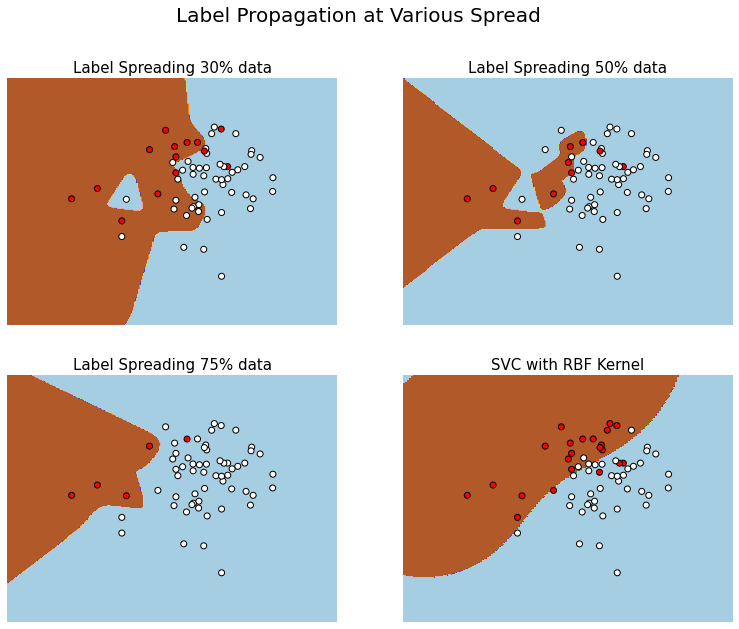

In [6]:
x_min, x_max = X[:, 0].min() -1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() -1, X[:, 1].max() + 1

h = 0.02
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
titles = ['Label Spreading 30% data', 'Label Spreading 50% data', 'Label Spreading 75% data', 'SVC with RBF Kernel']

plt.figure(figsize = (13, 10))
for i, (clf, y_train) in enumerate((ls30, ls50, ls75, rbf_svc)):
    plt.subplot(2, 2, i + 1)
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    plt.contourf(xx, yy, Z, cmap = plt.cm.Paired)
    plt.axis('off')

    colors = []
    for y in y_train:
        if   y == -1:
            color = (1, 1, 1)
        elif y ==  0:
            color = (1, 1, 1)
        elif y ==  1:
            color = (1, 0, 0)
        colors.append(color)
    plt.scatter(X[:, 0], X[:, 1], c = colors, edgecolors = 'black')
    plt.title(titles[i], size = 15)

plt.suptitle('Label Propagation at Various Spread', size = 20)
plt.show()


In [7]:
colon_data = pd.read_csv('../data/colon.csv')
X = colon_data[['T62947', 'H64807']].to_numpy()
y = colon_data[['Class']].to_numpy()

smote = SMOTE()
steps = [('over', smote), ('model', DecisionTreeClassifier())]
pipeline = Pipeline(steps = steps)

cv = RepeatedStratifiedKFold(n_splits = 15, n_repeats = 3, random_state = 1)
scores = cross_val_score(pipeline, X, y, scoring = 'roc_auc', cv = cv, n_jobs = -1)
print('Mean ROC AUC: %.3f' % mean(scores))

scores_list = []
for i in range(0, 10):
    scores = cross_val_score(pipeline, X, y, scoring = 'roc_auc', cv = cv, n_jobs = -1)
    print(f'\t Trial {i} Mean ROC AUC: %.3f' % mean(scores))
    scores_list.append(mean(scores))

Mean ROC AUC: 0.789
	 Trial 0 Mean ROC AUC: 0.807
	 Trial 1 Mean ROC AUC: 0.817
	 Trial 2 Mean ROC AUC: 0.809
	 Trial 3 Mean ROC AUC: 0.781
	 Trial 4 Mean ROC AUC: 0.798
	 Trial 5 Mean ROC AUC: 0.781
	 Trial 6 Mean ROC AUC: 0.844
	 Trial 7 Mean ROC AUC: 0.783
	 Trial 8 Mean ROC AUC: 0.750
	 Trial 9 Mean ROC AUC: 0.781


In [15]:
breast_df = pd.read_csv('../data/wdbc.data')
breast_df

,842302,M,17.99,10.38,122.8,1001,0.1184,0.2776,0.3001,0.1471,...,25.38,17.33,184.6,2019,0.1622,0.6656,0.7119,0.2654,0.4601,0.1189
0,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,...,24.990,23.41,158.80,1956.0,0.12380,0.18660,0.2416,0.1860,0.2750,0.08902
1,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,...,23.570,25.53,152.50,1709.0,0.14440,0.42450,0.4504,0.2430,0.3613,0.08758
2,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,...,14.910,26.50,98.87,567.7,0.20980,0.86630,0.6869,0.2575,0.6638,0.17300
3,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,...,22.540,16.67,152.20,1575.0,0.13740,0.20500,0.4000,0.1625,0.2364,0.07678
4,843786,M,12.45,15.70,82.57,477.1,0.12780,0.17000,0.15780,0.08089,...,15.470,23.75,103.40,741.6,0.17910,0.52490,0.5355,0.1741,0.3985,0.12440
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
563,926424,M,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,...,25.450,26.40,166.10,2027.0,0.14100,0.21130,0.4107,0.2216,0.2060,0.07115
564,926682,M,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,...,23.690,38.25,155.00,1731.0,0.11660,0.19220,0.3215,0.1628,0.2572,0.06637
565,926954,M,16.60,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,...,18.980,34.12,126.70,1124.0,0.11390,0.30940,0.3403,0.1418,0.2218,0.07820
566,927241,M,20.60,29.33,140.10,1265.0,0.11780,0.27700,0.35140,0.15200,...,25.740,39.42,184.60,1821.0,0.16500,0.86810,0.9387,0.2650,0.4087,0.12400
